## Análise exploratória de dados de queimadas
<hr style="border:2px solid #0077b9;">
- Obtendo os dados
- Explorando os dados

## 1. Obtendo dados
- Recupera feições de focos de queimadas

In [10]:
# Recuperar N focos de queimadas para cada região do Brasil
from simple_geo import simple_geo as sgeo
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.dataframe{font-size: 16px !important;}</style>"))

b = sgeo(wfs="http://localhost:8080/geoserver-esensing/", wtss="http://localhost:7654")
# recupera 500 focos de cada regiao
N=5
atributos=["timestamp","regiao","bioma","satelite","satelite_referencia"]
satelite_filter="(satelite='TERRA_M-M'+OR+satelite='TERRA_M-T'+OR+satelite='AQUA_M-M'+OR+satelite='AQUA_M-T')"
fc_n , _ = b.feature_collection("esensing:focos_bra_2016", attributes=atributos, filter=("regiao='N'",satelite_filter), max_features=N, sort_by='rand')
fc_ne, _ = b.feature_collection("esensing:focos_bra_2016", attributes=atributos, filter=("regiao='NE'",satelite_filter), max_features=N, sort_by='rand')
fc_co, _ = b.feature_collection("esensing:focos_bra_2016", attributes=atributos, filter=("regiao='CO'",satelite_filter), max_features=N, sort_by='rand')
fc_se, _ = b.feature_collection("esensing:focos_bra_2016", attributes=atributos, filter=("regiao='SE'",satelite_filter), max_features=N, sort_by='rand')
fc_s , _ = b.feature_collection("esensing:focos_bra_2016", attributes=atributos, filter=("regiao='S'",satelite_filter), max_features=N, sort_by='rand')

# concatenando os dados
focos = pd.concat([fc_n, fc_ne, fc_co, fc_se, fc_s], ignore_index=True)
display(focos.sample(n=5))

,bioma,coordinates,regiao,timestamp,geometry
743,Caatinga,"[-38.121, -7.829]",NE,2016-08-16T16:05:00Z,POINT (-38.121 -7.829)
1827,Mata Atlântica,"[-40.445, -20.618]",SE,2016-08-30T16:05:00Z,POINT (-40.445 -20.618)
905,Amazônia,"[-45.678, -2.912]",NE,2016-11-23T16:18:00Z,POINT (-45.678 -2.912)
494,Cerrado,"[-47.413, -9.369]",N,2016-10-15T16:50:00Z,POINT (-47.413 -9.369)
343,Amazônia,"[-48.664, -4.842]",N,2016-11-24T16:00:00Z,POINT (-48.664 -4.842)


- Para cada feição, obtem risco, temperatura, umidade e precipitação para local e dia do evento

In [11]:
# Para cada foco, obtem o valor de risco, precipitação, temperatura e umidade para o dia da ocorrência
dados = None
for index, row in focos.iterrows():
    s_date = datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d")
    ts, ts_metadata = b.time_series("rpth", 
                                    ("risk","precipitation", "temperature", "humidity"), 
                                    row['geometry'].y, row['geometry'].x,
                                    start_date=s_date, 
                                    end_date=s_date)
    # copia os atributos do ts para o foco
    ts['bioma'] = row['bioma']
    ts['regiao'] = row['regiao']
    ts['timestamp'] = row['timestamp']
    ts['satelite'] = row['satelite']
    ts['satelite_referencia'] = row['satelite_referencia']
    
    if dados is None:
        dados = ts;
    else:
        dados = pd.concat([dados, ts],ignore_index=True)

dados.sample(n=5)

,humidity,precipitation,risk,temperature,bioma,regiao,timestamp
106,0.459341,0.000000,0.712638,311.018280,Amazônia,N,2016-12-03T16:30:00Z
1943,0.203212,0.000000,1.000000,308.133545,Mata Atlântica,SE,2016-09-17T22:29:36Z
1388,0.231472,0.000000,1.000000,308.205048,Cerrado,CO,2016-08-24T16:51:41Z
673,0.307403,0.000000,1.000000,308.613037,Cerrado,NE,2016-08-18T16:35:00Z
2335,0.598763,0.091423,0.023480,286.302185,Mata Atlântica,S,2016-07-28T17:09:51Z


In [12]:
# Organizando os dados

# Removendo linhas com missing data
dados = dados[dados['risk']<=1]

# reordenando os dados
dados = dados[["risk", "precipitation", "humidity", "temperature", "bioma", "regiao", "timestamp"]]

# Convertendo temperatura de Kelvin para Celsius
dados["temperature"] = dados["temperature"]-273.15

# Convertendo para data
dados['timestamp'] = pd.to_datetime(dados['timestamp'])  

## 2. Explorando os dados
<hr style="border:2px solid #0077b9;">
- Todos os dados
- Por região (N, NE, CO, SE e S)
- Por bioma (Amazônia, Caatinga, Cerrado, Pantanal, Mata Atlântica e Pampa)
- Por estação (Primavera, Verão, Outono e Inverno)

In [13]:
# importando e configurando módulos de plotagem
import seaborn as sns
import numpy as np
from IPython.display import display, HTML 
from matplotlib import pyplot as plt
%matplotlib inline 

fig_size = (16,5)
palette=sns.diverging_palette(10, 240,  as_cmap=True)

siglas = ["N ", "NE", "CO", "SE", "S "]
titulos = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]

palette=sns.diverging_palette(240, 10,  as_cmap=True)

sns.set(font_scale=1.2)

### 2.1 Todos os dados

In [14]:
# Visão geral dos dados
dados.describe()

,risk,precipitation,humidity,temperature
count,2.445000e+03,2445.000000,2445.000000,2445.000000
mean,7.832390e-01,0.240514,0.389986,30.203471
std,3.354363e-01,1.354300,0.166902,5.165241
min,3.000701e-07,0.000000,0.112702,8.060266
25%,5.830897e-01,0.000000,0.262603,27.765741
50%,1.000000e+00,0.000000,0.355428,31.578058
75%,1.000000e+00,0.000000,0.484281,33.872186
max,1.000000e+00,19.725483,0.990000,40.782220


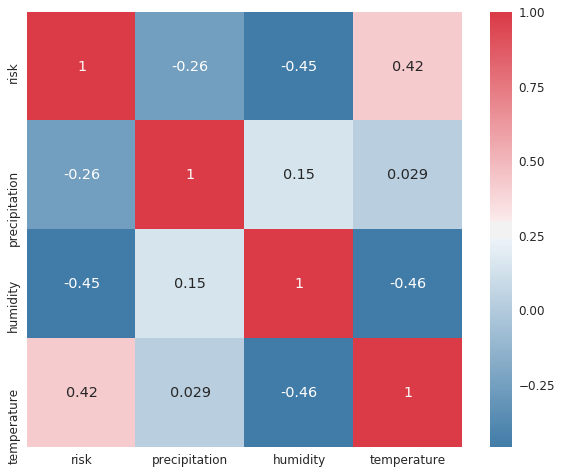

In [15]:
# Gerando matrix de correlação

f, ax = plt.subplots(figsize=(10, 8))
corr = dados.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
            square=True, ax=ax, annot=True)

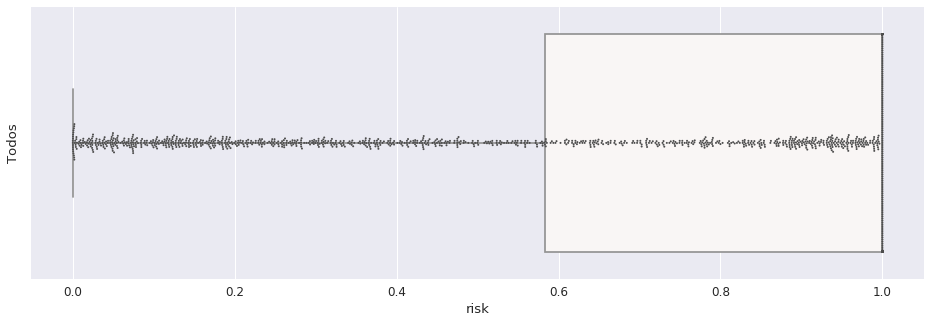

In [16]:
# Boxplot de todos os dados
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", data=dados, palette="vlag" )
sns.swarmplot(x="risk", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True) 
ax.set(ylabel="Todos")
sns.despine(trim=True, left=True)

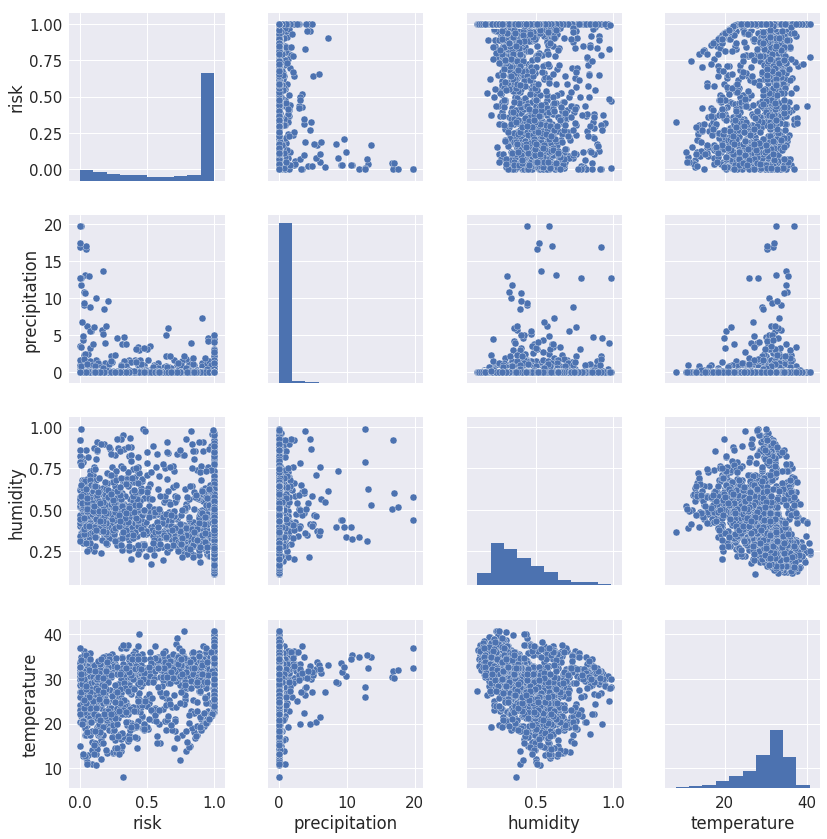

In [20]:
# Gerando scatterplot matrix
sns.set(font_scale=1.5)
sns.pairplot(dados, size=3)

### 2.2 Por região
<hr style="border:2px solid #0077b9;">
- N, NE, CO, SE e S

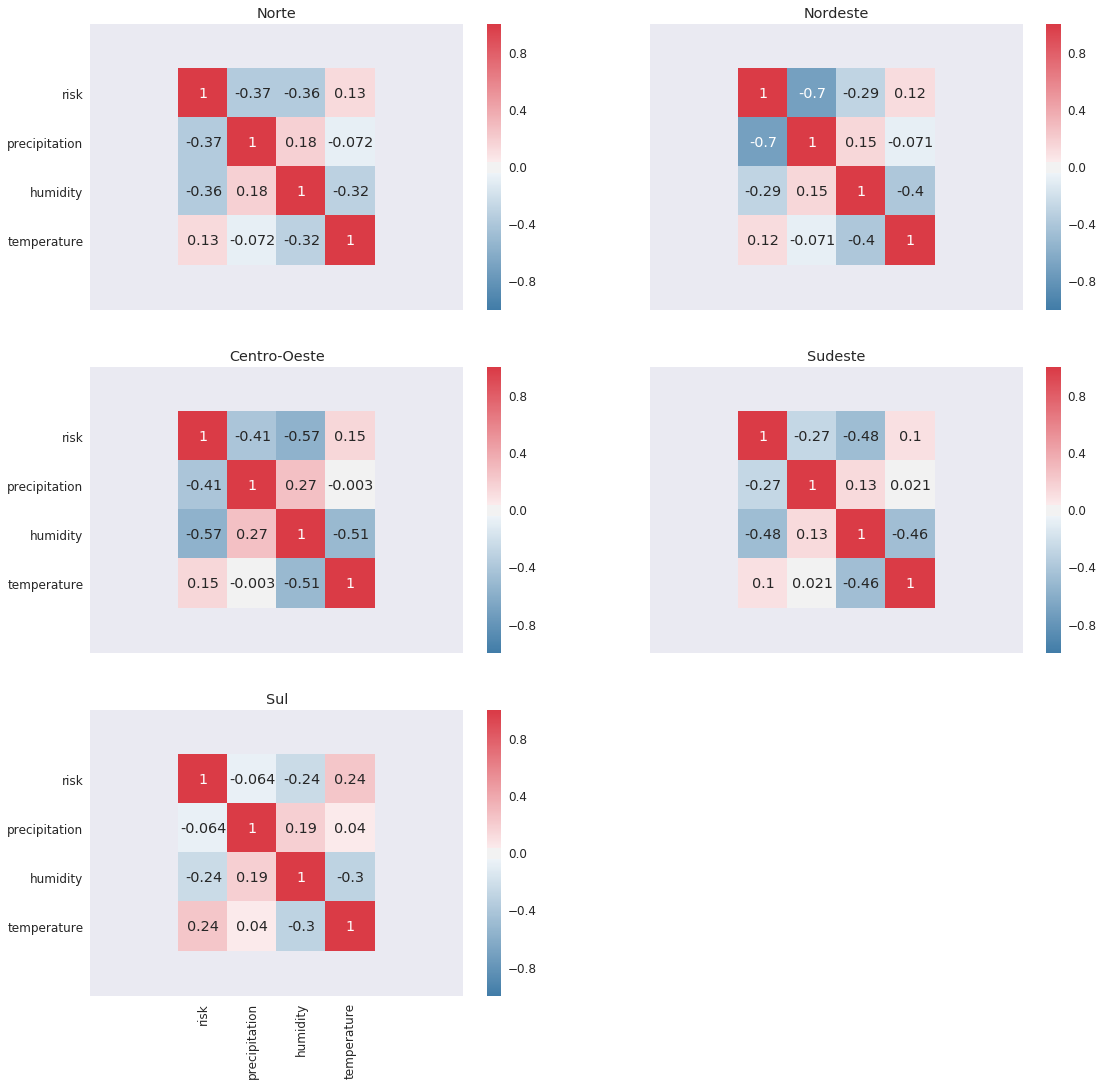

In [33]:
# Gerando matrix de correlação para cada região

sns.set(font_scale=1.2)
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    corr = dados[dados['regiao'] == siglas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(titulos[i])

ax[5].set_visible(False)
f.subplots_adjust(top=3.5, right=2.5)

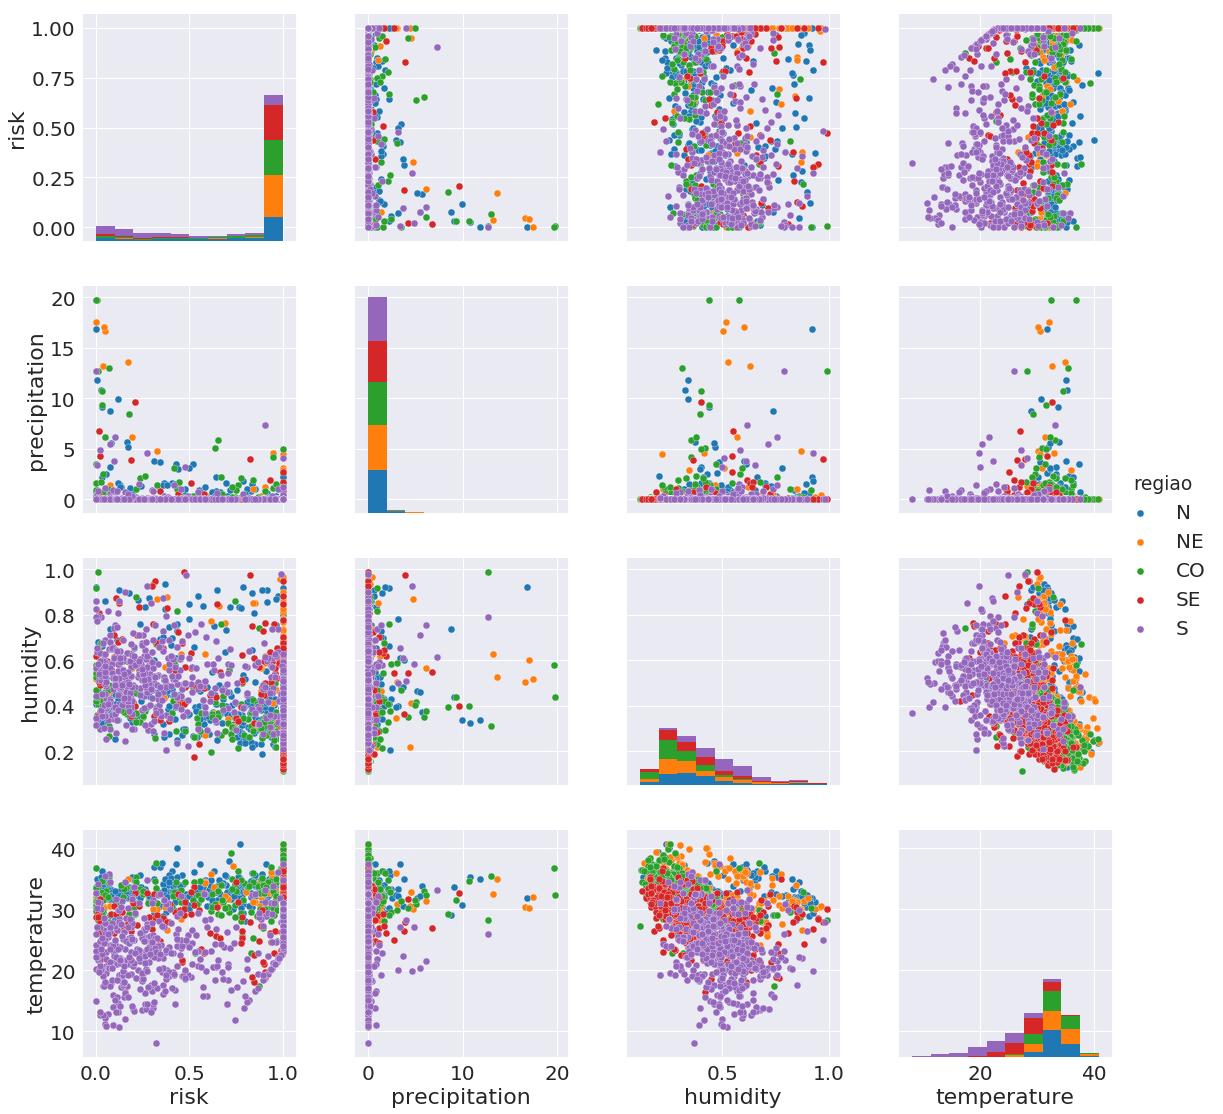

In [47]:
# Gerando scatterplot matrix por região
sns.set(font_scale=2)
color_regions = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
sns.pairplot(dados, hue="regiao", palette=sns.color_palette(color_regions), size=4)

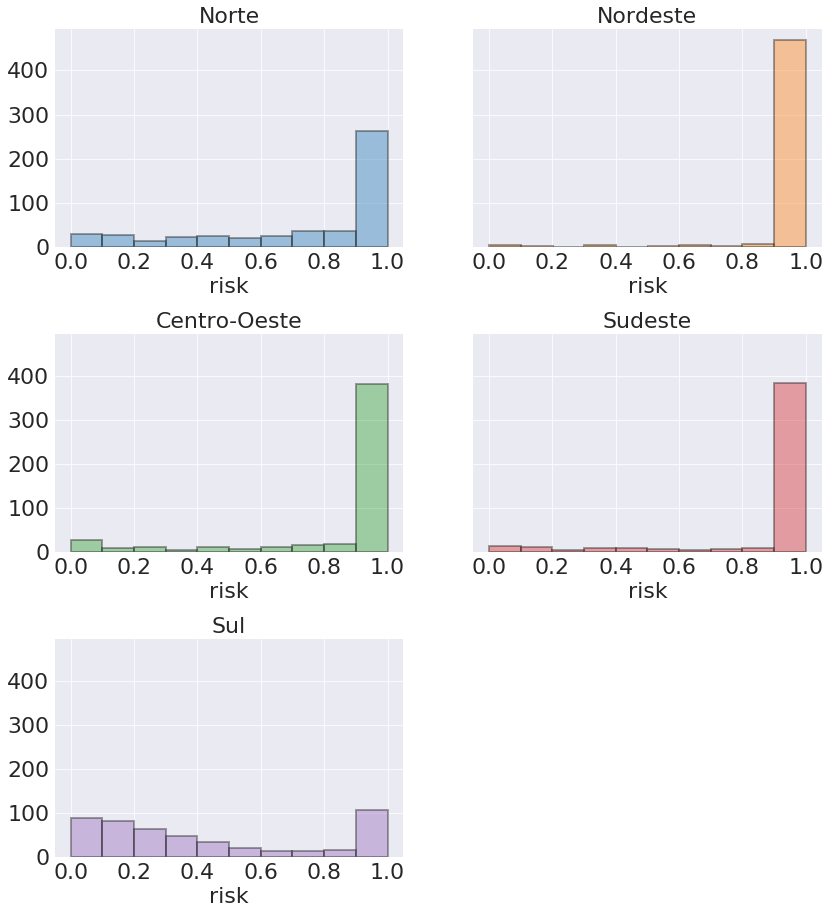

In [78]:
# Histogramas para cada região
from scipy import stats, integrate
sns.set(color_codes=True)

sns.set(font_scale=2)
sns.set_context("paper", rc={"font.size":28,"axes.titlesize":22,"axes.labelsize":22})   
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    sns.distplot(dados[dados['regiao'] == siglas[i]]["risk"], ax=ax[i], kde=False, bins=10, color=color_regions[i], hist_kws=dict(edgecolor="k", linewidth=2));
    ax[i].set_title(titulos[i])
    ax[i].tick_params(labelsize=22)
    plt.setp( ax[i].get_xticklabels(), visible=True)

ax[5].set_visible(False)
plt.subplots_adjust(hspace=0.4, top=3, right=1.9)

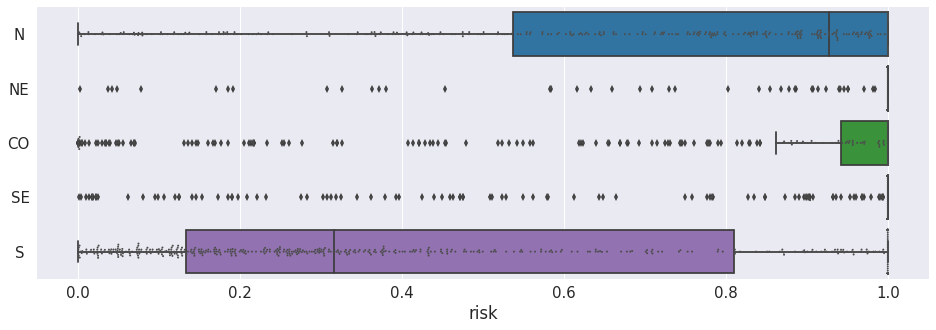

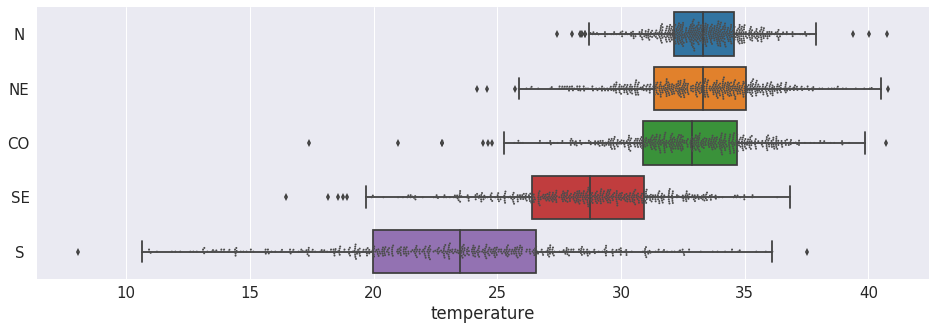

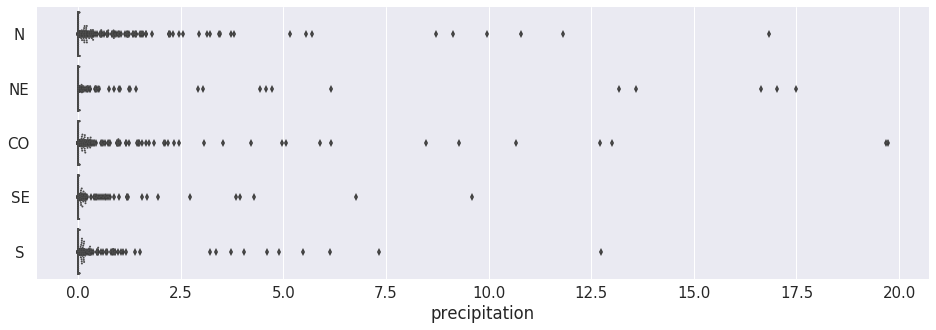

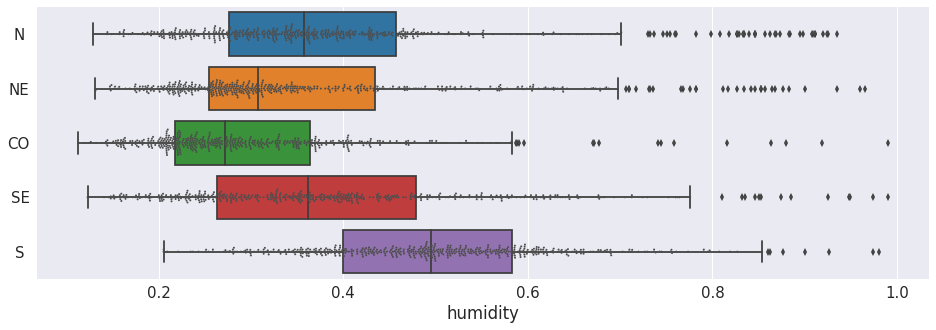

In [49]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por região

sns.set(font_scale=1.5)

for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var,  y="regiao", data=dados, palette=color_regions)
    sns.swarmplot(x=var, y="regiao", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)

### 2.3 Por bioma
<hr style="border:2px solid #0077b9;">
- Amazônia, Caatinga, Cerrado, Pantanal, Mata Atlântica e Pampa

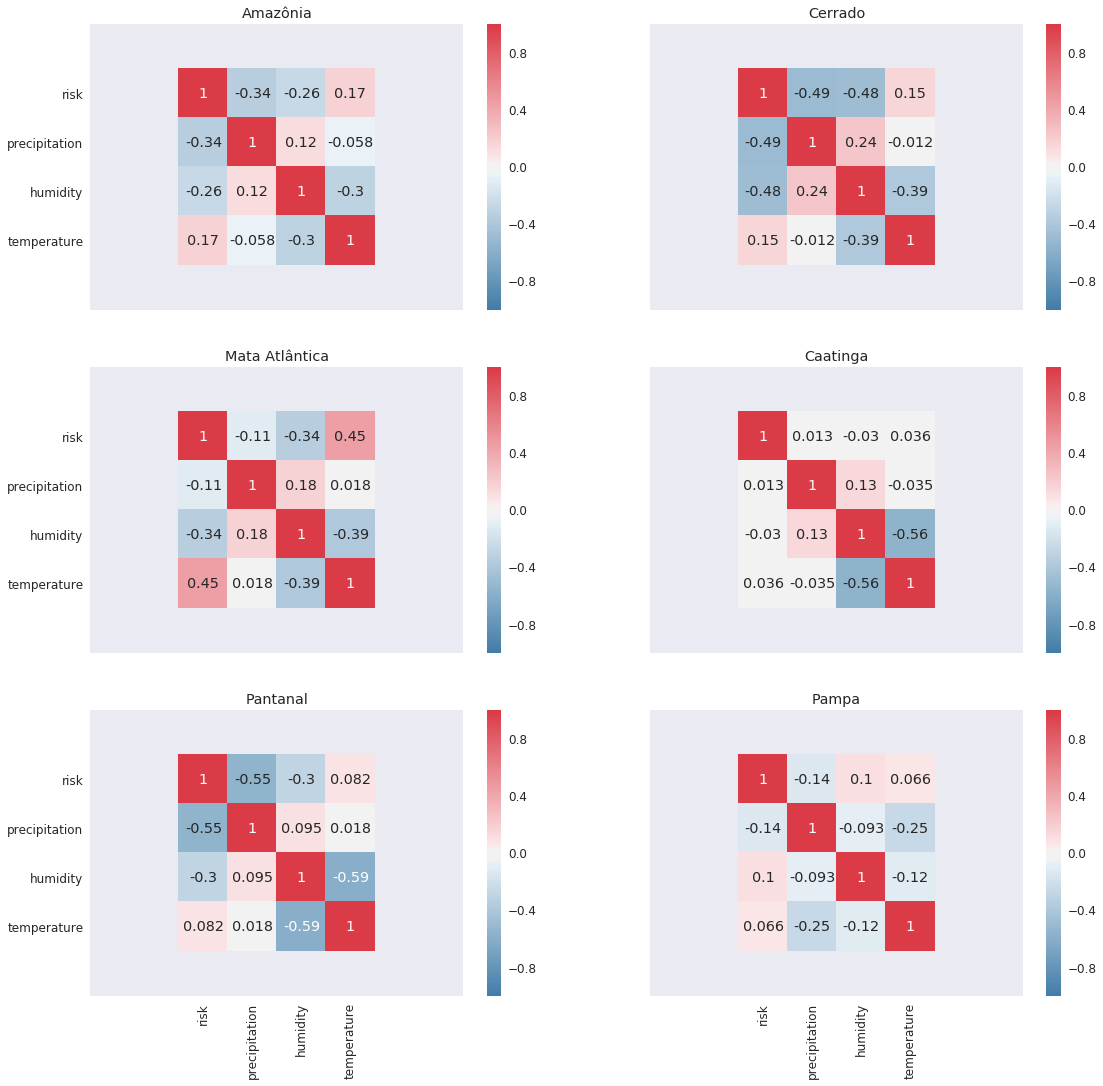

In [39]:
# Gerando matrix de correlação para cada bioma

biomas = dados['bioma'].unique()

sns.set(font_scale=1.2)
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in xrange(0, 6):
    corr = dados[dados['bioma']==biomas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(biomas[i])

f.subplots_adjust(top=3.5, right=2.5)

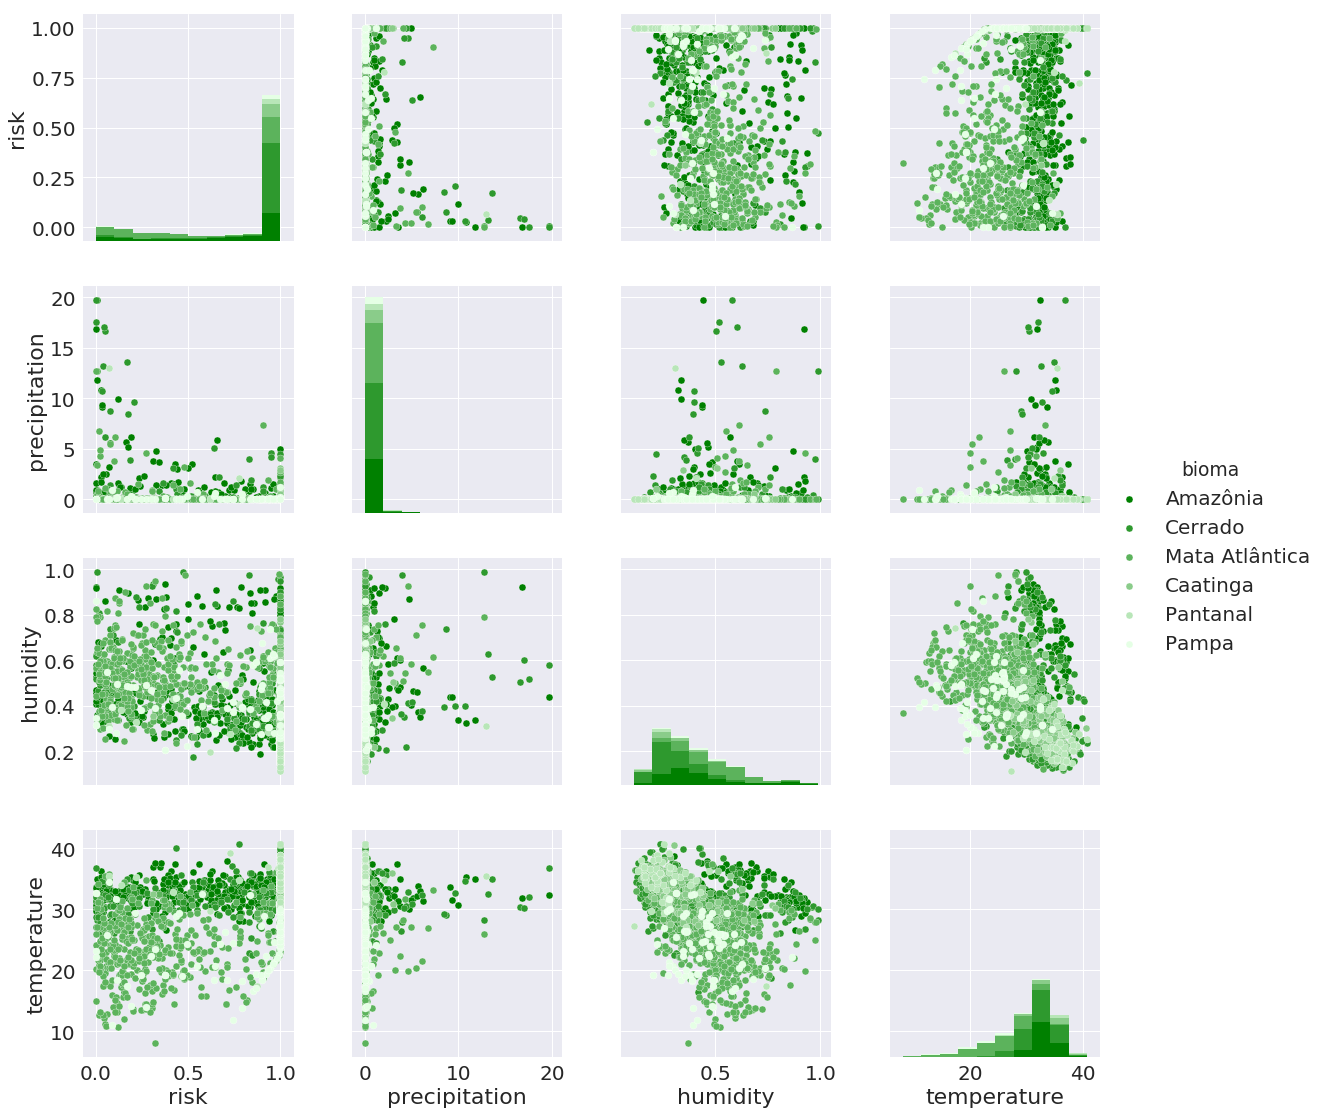

In [53]:
# Gerando scatterplot matrix por bioma
sns.set(font_scale=2)
bioma_colors=sns.light_palette("green",reverse=True).as_hex()
sns.pairplot(dados, hue="bioma", palette=sns.color_palette(bioma_colors), size=4)

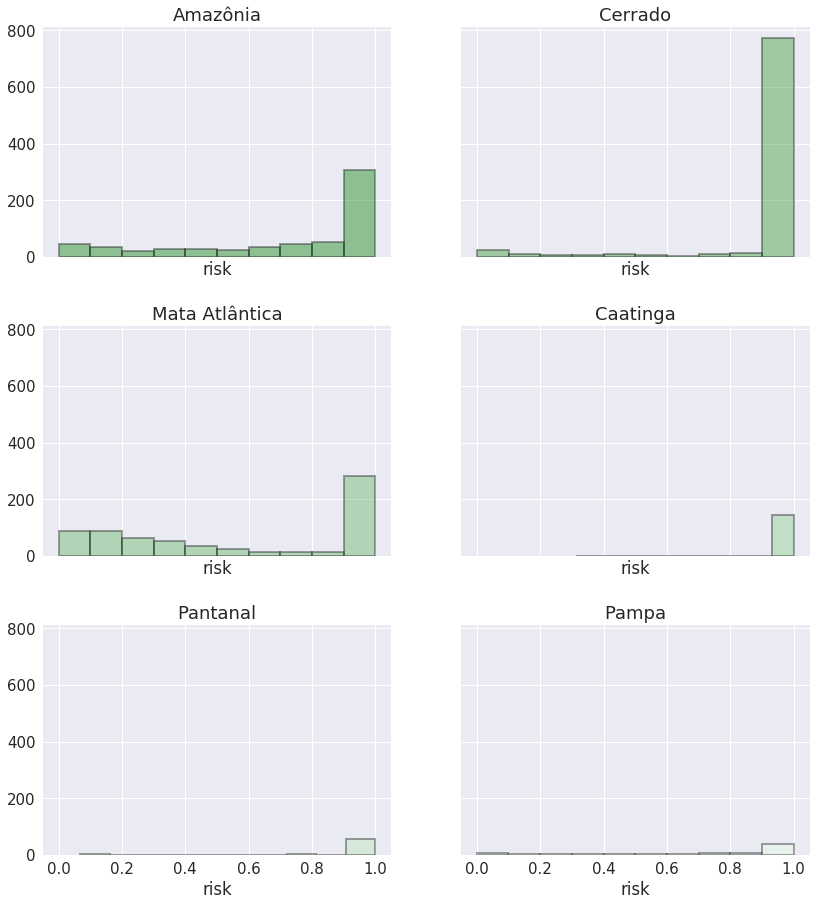

In [55]:
# Histogramas para cada região

from scipy import stats, integrate
sns.set(color_codes=True)
sns.set(font_scale=1.5)
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2 , sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 6):
    sns.distplot(dados[dados['bioma']==biomas[i]]["risk"], ax=ax[i], kde=False, rug=False, bins=10, color=bioma_colors[i],
                hist_kws=dict(edgecolor="k", linewidth=2));
    ax[i].set_title(biomas[i])

plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

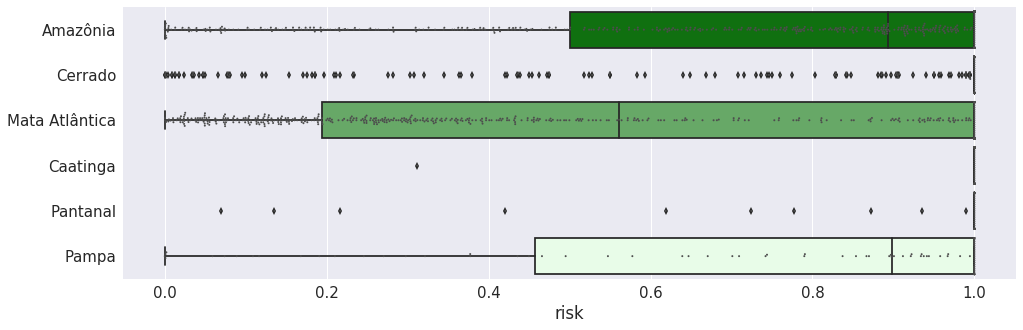

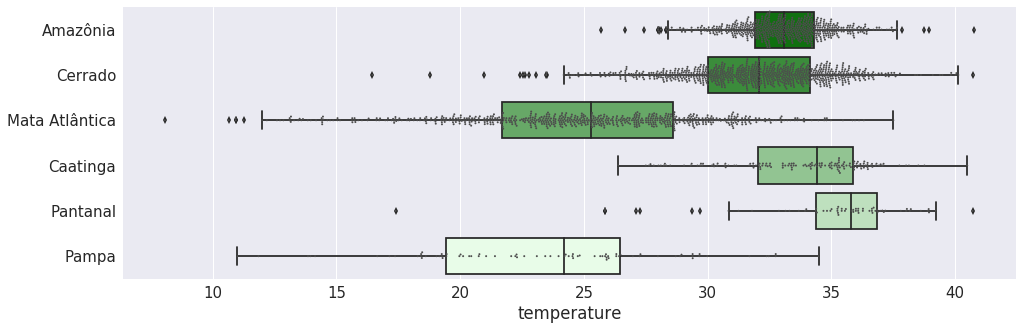

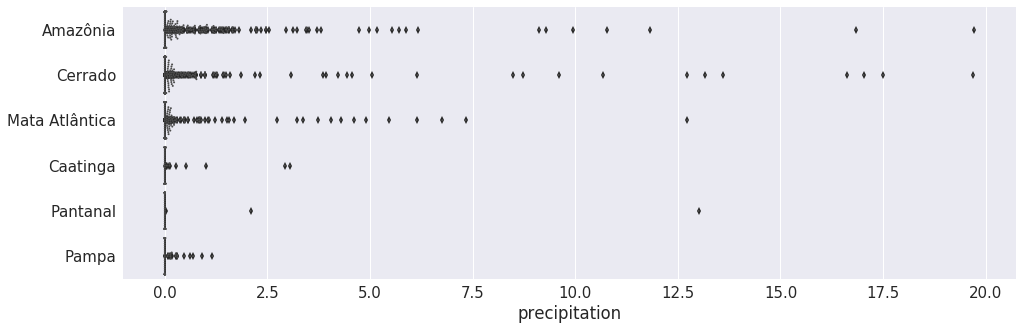

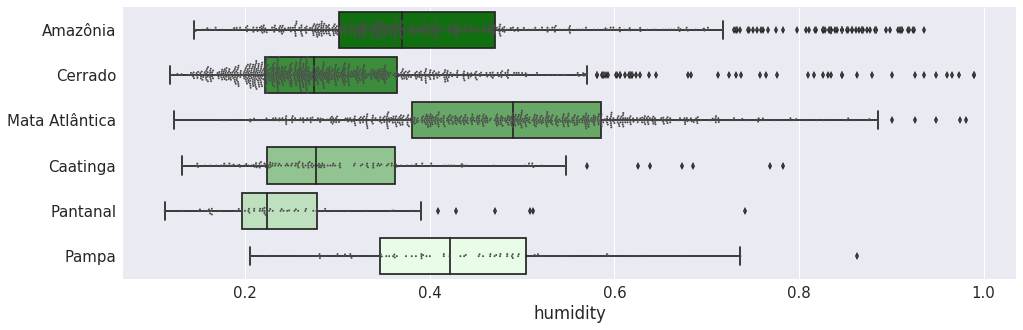

In [63]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por bioma

sns.set(font_scale=1.5)
for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var, y="bioma", data=dados, palette=bioma_colors)
    sns.swarmplot(x=var, y="bioma", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)

### Por estações
<hr style="border:2px solid #0077b9;">
- Primavera, Verão, Outono e Inverno

In [57]:
# Separando dados por estação

# períodos das estacoes no hemisfério sul
primavera = (dados['timestamp'] > '2016-09-23') & (dados['timestamp'] <= '2016-12-21')
verao = (dados['timestamp'] > '2016-12-21') | ( (dados['timestamp'] >= '2016-01-01') & (dados['timestamp'] < '2016-03-21') )
outono = (dados['timestamp'] > '2016-03-21') & (dados['timestamp'] <= '2016-06-20')
inverno = (dados['timestamp'] > '2016-06-20') & (dados['timestamp'] <= '2016-09-23')

# Criando coluna estacao
dados['estacao']=''
dados.loc[primavera, 'estacao']="primavera"
dados.loc[verao, 'estacao']="verao"
dados.loc[outono,'estacao']="outono"
dados.loc[inverno, 'estacao']='inverno'

# Contado por grupo de risco e por estação
dados.filter(items=["risk", "estacao"])\
     .groupby(["estacao",pd.cut(dados["risk"], np.arange(0, 1+.25, .25))])\
     .count().rename(columns={'risk':'Total'})

Total
estacao   risk              
inverno   (0.0, 0.25]    143
          (0.25, 0.5]     88
          (0.5, 0.75]     76
          (0.75, 1.0]   1066
outono    (0.0, 0.25]     32
          (0.25, 0.5]     31
          (0.5, 0.75]     13
          (0.75, 1.0]     82
primavera (0.0, 0.25]    124
          (0.25, 0.5]     81
          (0.5, 0.75]     49
          (0.75, 1.0]    514
verao     (0.0, 0.25]     47
          (0.25, 0.5]     17
          (0.5, 0.75]     12
          (0.75, 1.0]     70

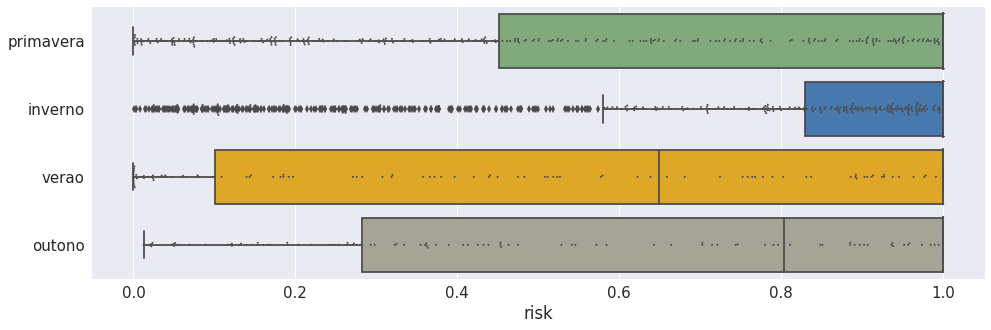

In [72]:
# Boxplot para Estação-Risco

colors = ["faded green", "windows blue", "amber", "greyish"]
colors_estacoes = sns.xkcd_palette(colors).as_hex()

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", y="estacao", data=dados, palette=colors_estacoes)
sns.swarmplot(x="risk", y="estacao", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

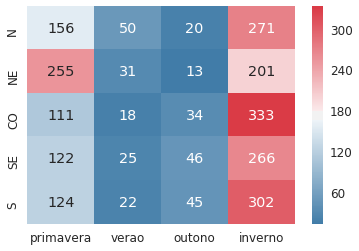

In [73]:
# Ocorrências por Região-Estação

sns.set(font_scale=1.2)
estacao_regiao=pd.DataFrame(index=("N ", "NE", "CO", "SE", "S "))
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for regiao in ("N ", "NE", "CO", "SE", "S "):
        estacao_regiao.set_value(regiao, estacao, len(dados.loc[ (dados['estacao']==estacao) & (dados['regiao']==regiao)]))

sns.heatmap(estacao_regiao, cmap=palette, annot=True,  fmt='g')

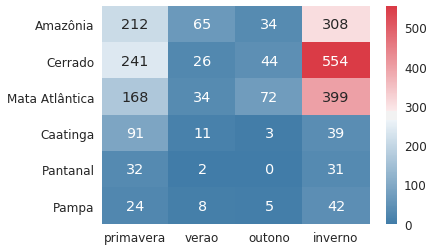

In [74]:
# Ocorrências por Bioma-Estação
sns.set(font_scale=1.2)
estacao_bioma=pd.DataFrame(index=dados['bioma'].unique())
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for bioma in dados['bioma'].unique():
        estacao_bioma.set_value(bioma,estacao, len(dados.loc[ (dados['estacao']==estacao) & (dados['bioma']==bioma)]))

sns.heatmap(estacao_bioma, cmap=palette, annot=True, fmt='g')

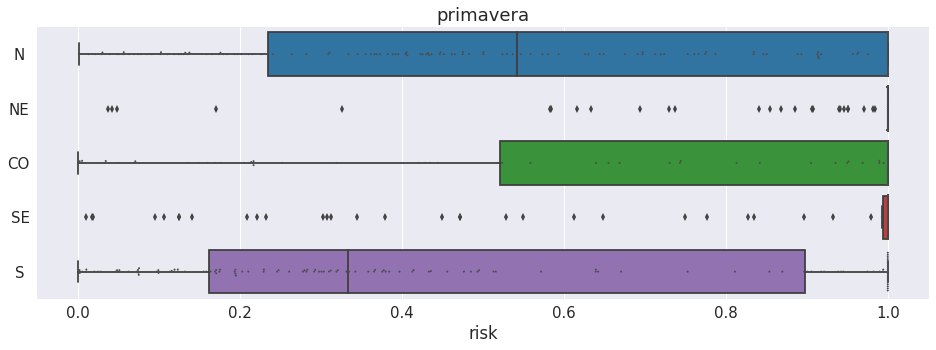

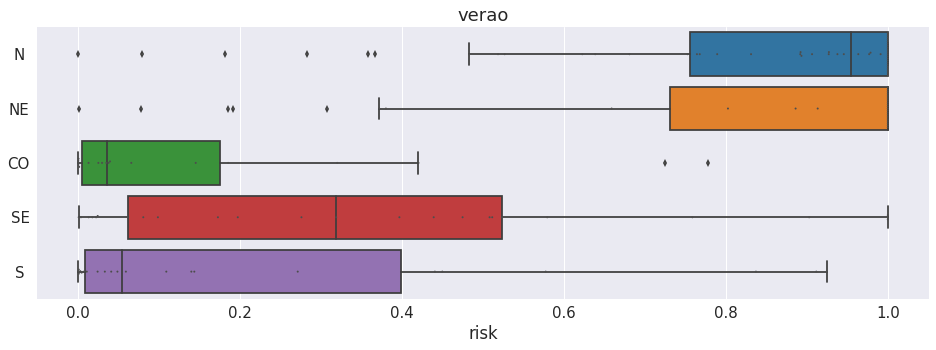

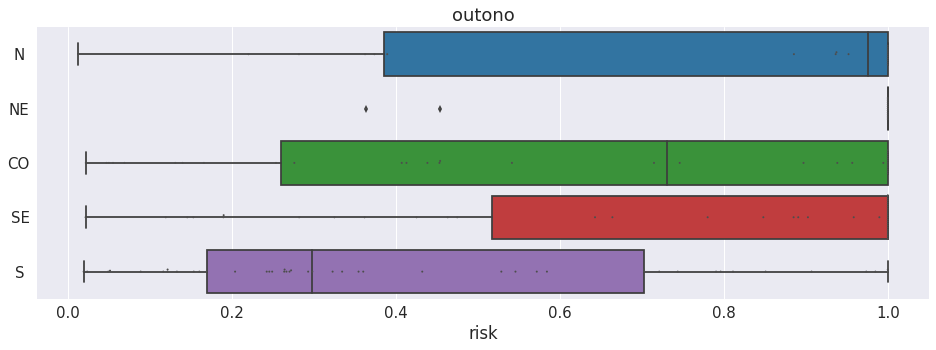

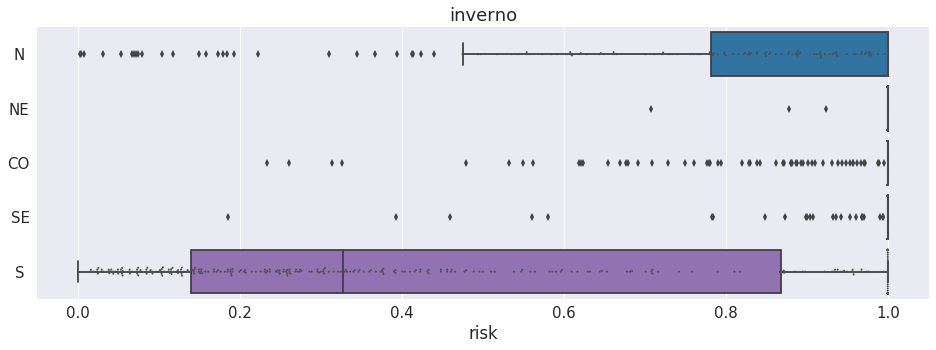

In [75]:
# Boxplot Região-Estação

sns.set(font_scale=1.5)
for estacao,i in zip(("primavera", "verao", "outono", "inverno"), xrange(0,5)): 
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao] , palette=color_regions, ax=ax)
    sns.swarmplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_title(estacao)

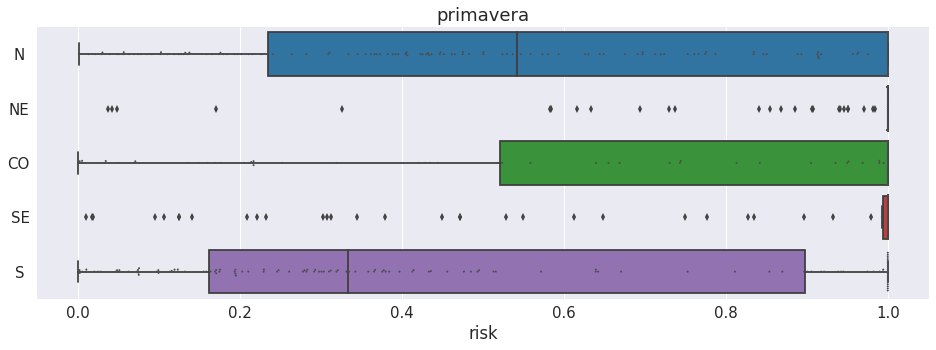

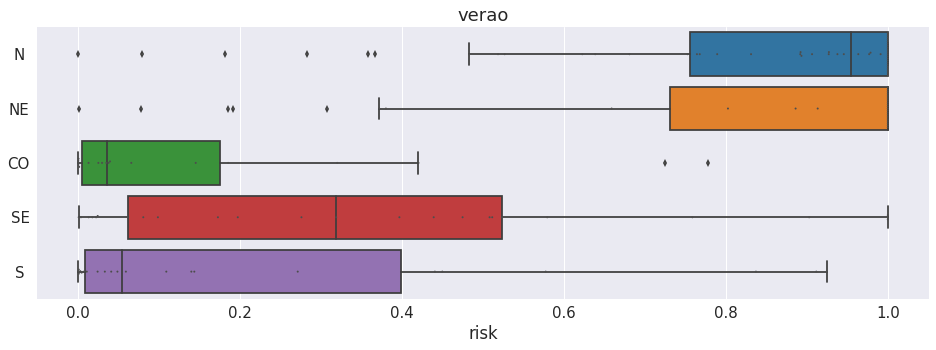

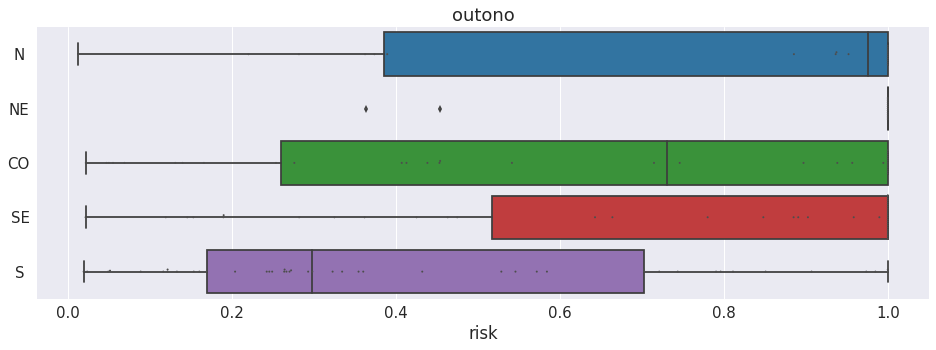

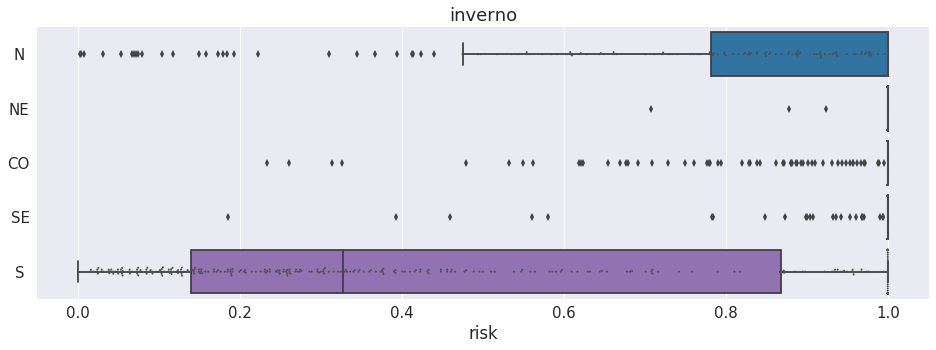

In [76]:
# Boxplot Região-Estação

sns.set(font_scale=1.5)
for estacao,i in zip(("primavera", "verao", "outono", "inverno"), xrange(0,5)): 
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao] , palette=color_regions, ax=ax)
    sns.swarmplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_title(estacao)

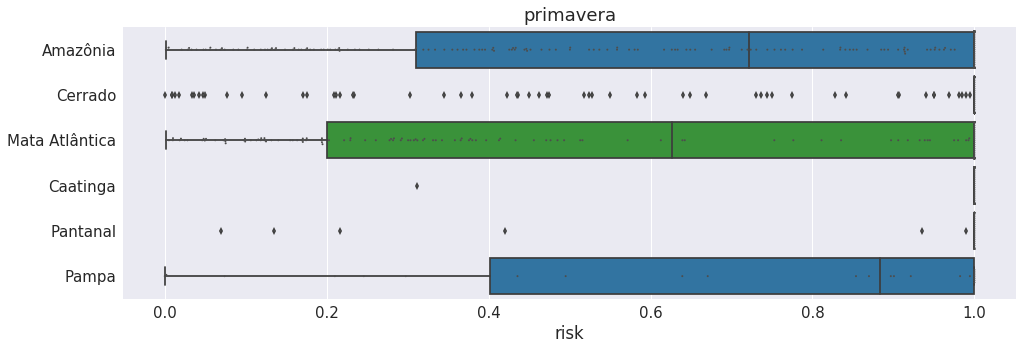

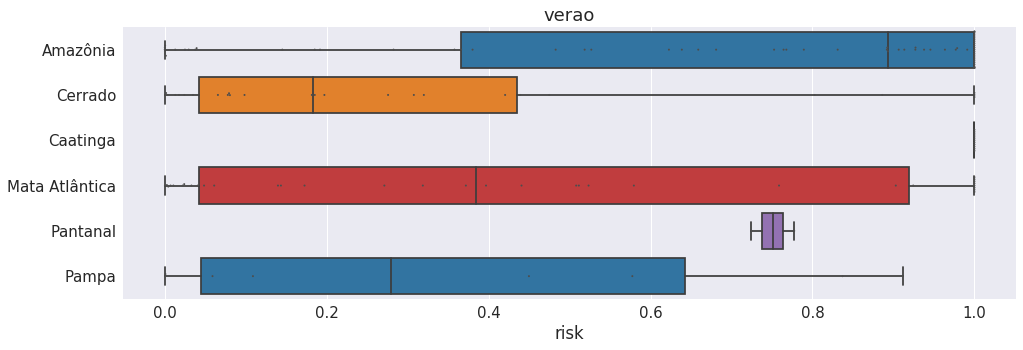

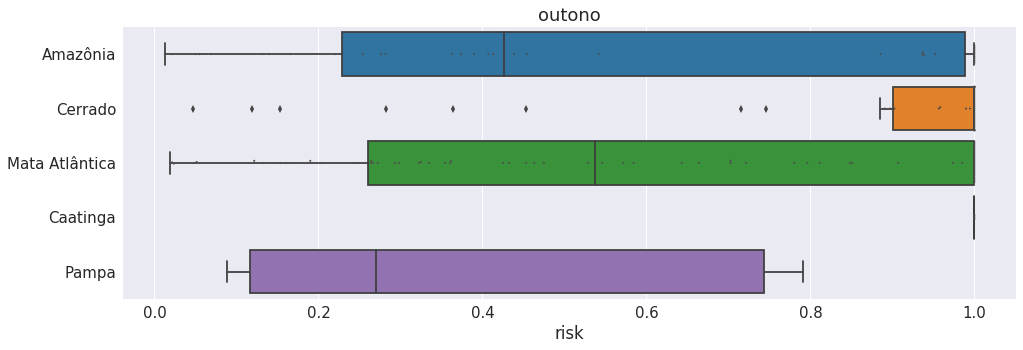

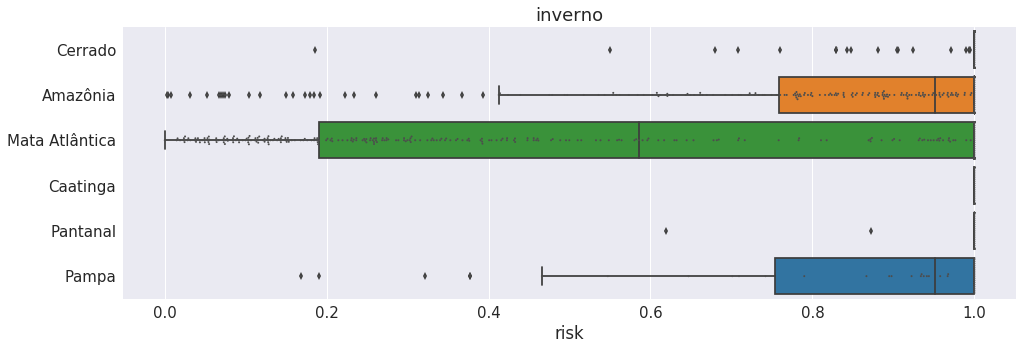

In [77]:
# Boxplot Bioma-Estação

for estacao,i in zip(("primavera", "verao", "outono", "inverno"), xrange(0,5)): 
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(x="risk", y="bioma", data=dados.loc[dados['estacao']==estacao] , palette=color_regions, ax=ax)
    sns.swarmplot(x="risk", y="bioma", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_title(estacao)

## Links
<hr style="border:2px solid #0077b9;">

- **simple_geo.py**: [http://github.com/vconrado/simple_geo.py/](http://github.com/vconrado/simple_geo.py/)
- **WTSS.py**: [https://github.com/e-sensing/wtss.py](https://github.com/e-sensing/wtss.py)
